In [1]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
%matplotlib inline

import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import pandas as pd
import scipy.fftpack as fftp
import os
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

STFT on noise: 0:00:00.154159
STFT on signal: 0:00:00.143281
[64.01752  56.31745  40.778072 ... 22.148096 22.179258 24.944891] -17.465607
Masking: 0:00:00.101944
Mask convolution: 0:00:00.218503
Mask application: 0:00:00.462069
Signal recovery: 0:00:00.217749


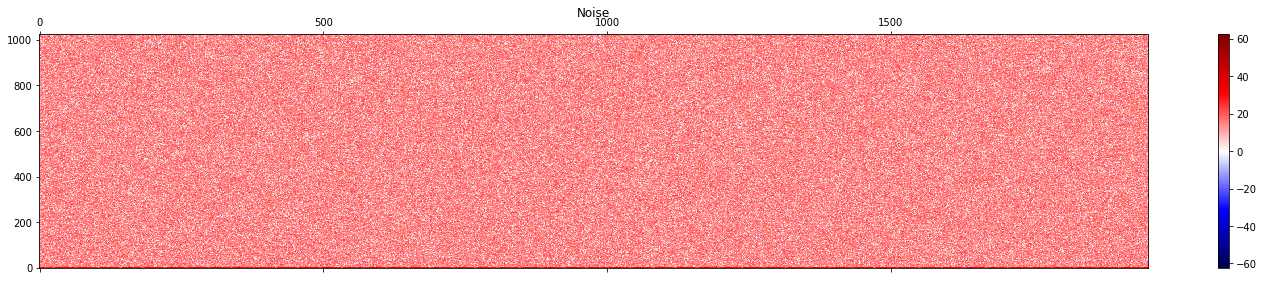

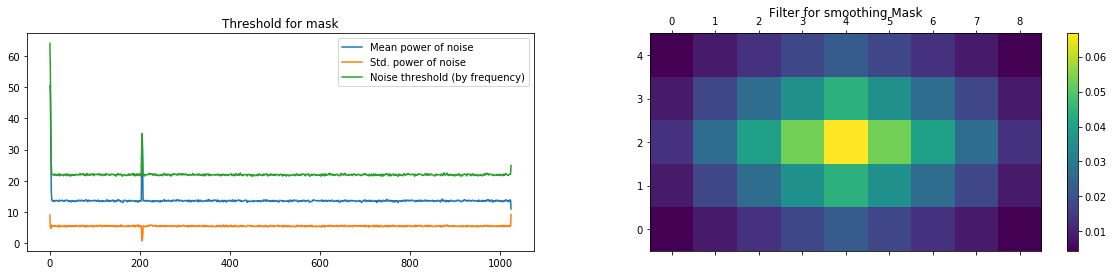

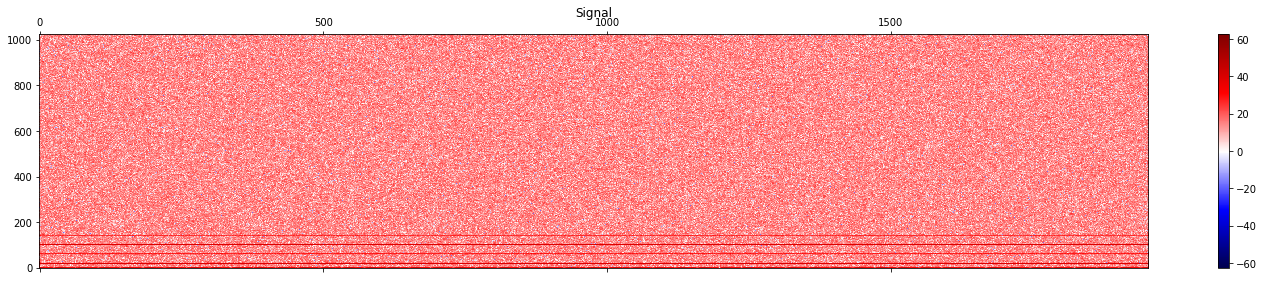

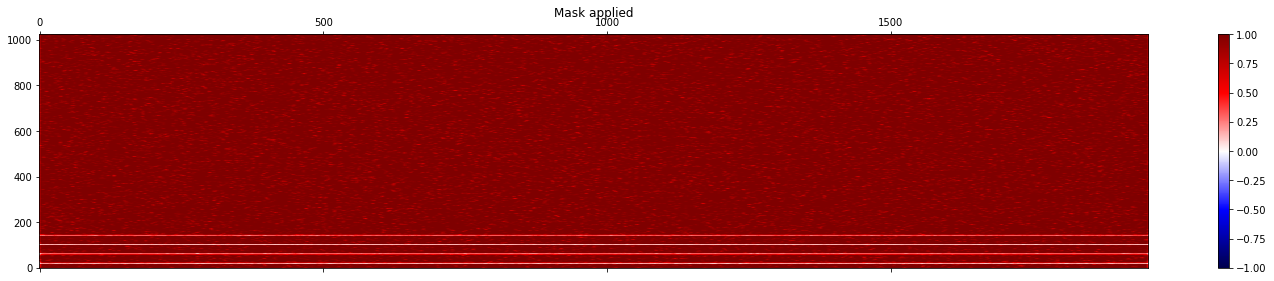

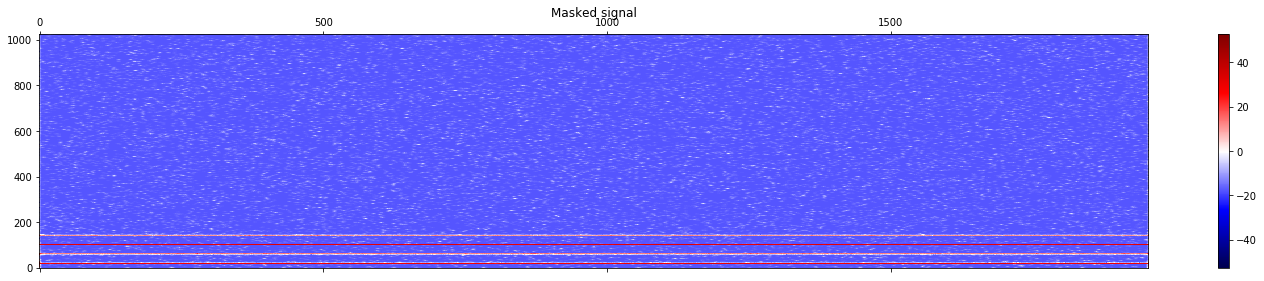

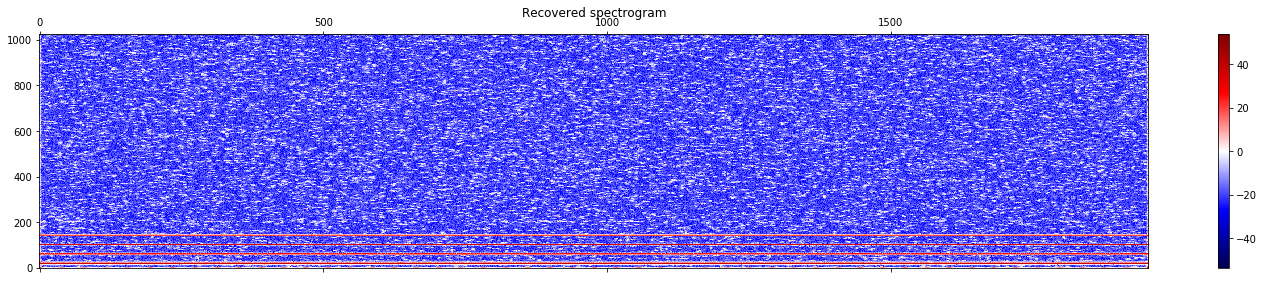

In [10]:
t= np.linspace(0,200,2000000)
t1= np.linspace(0,200,2000000)
t_fin = np.linspace(0,200,2000000)

t[:1000000] = 0
# t[199999:] = 0
wave1 = np.sin(100*2*np.pi*t)+0.3333*np.sin(300*2*np.pi*t)+0.2*np.sin(500*2*np.pi*t)+0.1429*np.sin(700*2*np.pi*t)#+np.sin(25*2*np.pi*t)
# t1[:160000]= 0
# t1[179999:]= 0
# wave2 = np.sin(25*2*np.pi*t1)
freq_val = [10]#,25]
loc = [1999999]#,179999]
wave = wave1#+wave2
geo = 0.8*np.random.random(len(wave))+0.35*np.sin(2*2*np.pi*t_fin+0.125*np.pi)+0.4*np.sin(3*2*np.pi*t_fin+0.25*np.pi)+0.1*np.sin(1000*2*np.pi*t_fin+0.5*np.pi)+0.3*np.sin(2.5*2*np.pi*t_fin+0.33*np.pi)

transf_s = 0.5*np.ones(len(wave))
frq = np.fft.fftfreq(len(wave),1/10000)
transf_sample = scipy.interpolate.interp1d(frq,transf_s, kind='linear')

output = removeNoise(audio_clip=wave[1000000:]+geo[1000000:], noise_clip=geo[:1000000],verbose=True,visual=True)

(0, 300)

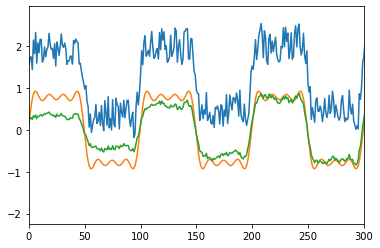

In [11]:
plt.plot(wave[1000000:]+geo[1000000:])
plt.plot(wave[1000000:])
plt.plot(output)

plt.xlim(0,300)

(-1, 1010)

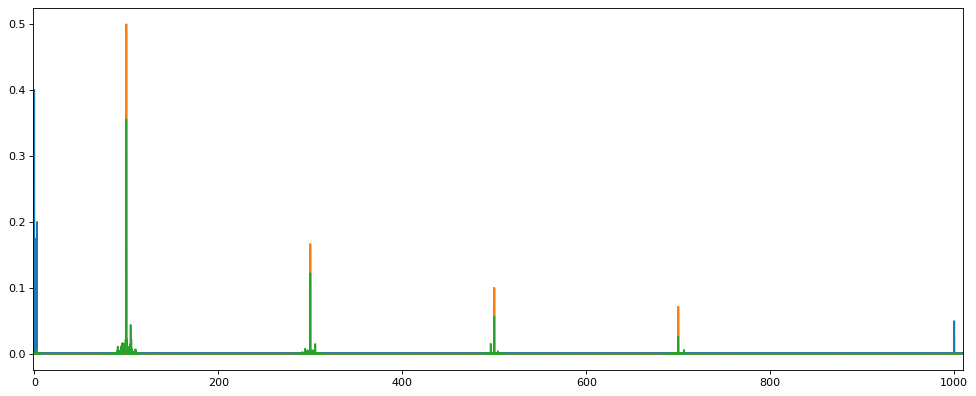

In [5]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
output_fft = np.fft.fft(output)/len(output)
wave_fft = np.fft.fft(wave[1000000:])/len(wave[1000000:])
full_fft = np.fft.fft(wave[1000000:]+geo[1000000:])/len(wave[1000000:])
freq = np.fft.fftfreq(len(output_fft),1/10000)
plt.plot(freq[:int(len(freq)/2)],abs(full_fft[:int(len(freq)/2)]))
plt.plot(freq[:int(len(freq)/2)],abs(wave_fft[:int(len(freq)/2)]))
plt.plot(freq[:int(len(freq)/2)],abs(output_fft[:int(len(freq)/2)]))

plt.xlim(-1,1010)

In [6]:
print(np.mean(output))

0.0013163631


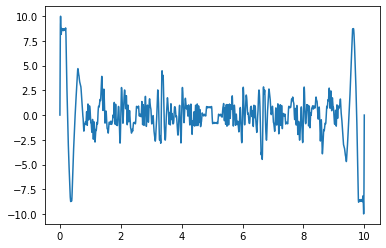

In [7]:
sinner = [1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]
t = np.linspace(0,10,100000)
wave = np.zeros(len(t))
for freq in sinner:
    wave = wave+ np.sin(freq*2*np.pi*t)
    for harm in np.arange(5):
        harm = harm*2+3
        wave = wave+ (1/harm)*np.sin(freq*harm*2*np.pi*t)
#     plt.plot(t,wave)
    
plt.plot(t,wave)
# plt.xlim(0,1)

(0, 100)

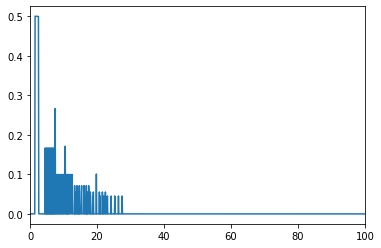

In [8]:
freq = np.fft.fftfreq(len(wave),1/10000)
fft = np.fft.fft(wave)/len(wave)
plt.plot(freq[:int(len(fft)/2)],abs(fft[:int(len(fft)/2)]))
plt.xlim(0,100)